# Astar Consulting - LangGraph Workshop
<div style="text-align:center">
    <img src="./images/Astar Consulting.png" alt="levels of automation" width='80%'>
</div>

Welcome to the LangGraph Workshop! This workshop is designed to help you understand the basic concepts of building LLM applications with a focus on the LangGraph library.

**Astar Consulting:**
- [Website](https://www.astarconsulting.no/)
- [LinkedIn](https://www.linkedin.com/company/astarconsulting)

- [Erik Nymo Bohne](https://www.linkedin.com/in/erik-nymo-bohne-25868321a/)
- [Mikael Steenbuch](https://www.linkedin.com/in/mikael-steenbuch/)

## Sources

- [Langchain](https://python.langchain.com/v0.2/docs/introduction/)🦜
- [Langgraph](https://langchain-ai.github.io/langgraph/tutorials/introduction/)🕸️
- [Langsmith](https://docs.smith.langchain.com/)🛠️

## Levels of automation - Motivation
The rapid development in large language models and frameworks has made it possible to automate a wide range of tasks. The levels of automation can be seen as a scale of how much human intervention is needed to complete a task. The scale ranges from 1 to 6, where 1 is no automation and 6 is full automation. With LangGraph we are designing systems to achieve level 4 and 5, and even reacing level 6 in some cases.
<div style="text-align:center">
    <img src="./images/LevelsOfAutomation.png" alt="levels of automation" width='80%'>
</div>

## Prerequisites

### Create Tavily user, and get your api key
Go to: [Tavily, sign in](https://app.tavily.com/sign-in), and register a new user


### Install the required packages

In [1]:
%pip install -U langgraph langsmith langchain_openai langchain_community

     ---------------------------------------- 0.0/44.7 kB ? eta -:--:--
     ---------------------------------------- 44.7/44.7 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/153.3 kB ? eta -:--:--
   ---------------------------------------- 153.3/153.3 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/375.8 kB ? eta -:--:--
   ------------------------------ --------- 286.7/375.8 kB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 375.8/375.8 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/74.5 kB ? eta -:--:--
   ---------------------------------------- 74.5/74.5 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/43.9 kB ? eta -:--:--
   ---------------------------------------- 43.9/43.9 kB 2.1 MB/s eta 0:00:00
   ---------------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\simen\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Set environment variables

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

### 1. The State of the graph
The first thing you do when you define a graph is define the `State` of the graph. The `State` consists of the schema of the graph as well as `reducer functions` which specify how to apply updates to the state. The schema of the `State` will be the input schema to all `Nodes` and `Edges` in the graph, and can be either a `TypedDict` or a `Pydantic` model. All `Nodes` will emit updates to the `State` which are then applied using the specified reducer function.

Source: [Langchain AI - State of the graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)


In [2]:
from typing import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

### 2. Nodes for the graph
In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).

Source: [Langchain AI - Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model_name="gpt-4o-mini",
)

def chatbot(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm.invoke(state["messages"])]}

In [4]:
message = ("human", "Hva heter hovedstaden i Norge?")
chatbot({"messages": [message]})

{'messages': [AIMessage(content='Hovedstaden i Norge heter Oslo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 15, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CYuqdzFWRThFJRvDNmO3Jd2F3A9Y0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--35d037da-e9a8-4ca5-8ddb-f48f5ba0b25c-0', usage_metadata={'input_tokens': 15, 'output_tokens': 9, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

### 3. Edges - The workflow of the graph
Edges define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- **Normal Edges**: Go directly from one node to the next.
- **Conditional Edges**: Call a function to determine which node(s) to go to next.
- **Entry Point**: Which node to call first when user input arrives.
- **Conditional Entry Point**: Call a function to determine which node(s) to call first when user input arrives.

A node can have **MULTIPLE** outgoing edges. If a node has multiple out-going edges, **all** of those destination nodes will be executed in parallel as a part of the next superstep.

Source: [Langchain AI - Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)

In [5]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Adding nodes to the workflow
workflow.add_node("chatbot", chatbot)

# Defining edges between nodes
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

graph = workflow.compile()


### Lets take a look at our graph

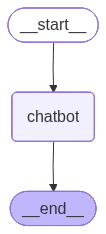

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke/stream the graph
LangGraph is built with first class support for streaming. There are several different ways to stream back results from the graph.

Source: [Langchain AI - Streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)

In [7]:
while True:
    user_input = input("User: ")
    print("User: " + user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: Hvor mange bor i Norge?
Assistant: Per oktober 2023 er befolkningen i Norge anslått til å være omtrent 5,4 millioner mennesker. Befolkningstallet kan imidlertid endre seg, så det kan være lurt å sjekke den nyeste statistikken fra Statistisk sentralbyrå for oppdatert informasjon.
User: exit
Goodbye!


### 4. Lets add tools to the graph

It's extremely common to want agents to do tool calling. Tool calling refers to choosing from several available tools, and specifying which ones to call and what the inputs should be. This is extremely common in agents, as you often want to let the LLM decide which tools to call and then call those tools.

Source: [Langchain AI - Tools](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling)

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

 # Get your key from https://app.tavily.com/sign-in

tool = TavilySearchResults(max_results=3)
tools = [tool]
print("Tavily key loaded")
print(tool.name)  

Tavily key loaded
tavily_search_results_json


In [10]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

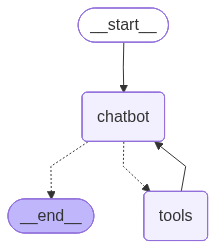

In [11]:
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(GraphState)

# Adding nodes to the workflow
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", ToolNode(tools))

# Defining edges between nodes
workflow.add_edge(START, "chatbot")
workflow.add_edge("tools", "chatbot")

# Defining conditional edges
workflow.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  Hva er siste nytt om aksjemarkedet?
Assistant: 
Assistant: [{"title": "November 2025 Stock Market Outlook: Where We See Investment ...", "url": "https://www.morningstar.com/stocks/november-2025-stock-market-outlook-where-we-see-investment-opportunities", "content": "As of Oct. 31, 2025, the US equity market was trading at a 2% discount to a composite of our fair value estimates of the over 700 stocks we cover that trade on US exchanges. While the Morningstar US Market Index rose a healthy 2.21% in October, a composite of the market capitalization of those stocks under our coverage had risen even faster. In fact, the total market capitalization of our valuations rose by $4.2 trillion, which is over 5% of the market capitalization of the stocks we cover. By [...] Romanoff, CPA Nov 6, 2025 [...] Valuation increases surge in October, taking market valuation to a slight discount.\n   Big gets bigger, and concentration becomes more concentrated.\n   Style and sector dynamics: growth p

## TASK 1: CREATE YOUR OWN TOOL

#### Suggestions:

**Easy:**
1. Create a tool that performs a simple mathematical operation (e.g. addition, matrix multiplication, etc.)
2. Create a tool that performs a simple string operation (e.g. string concatenation, string split, etc.)

**Medium:**
1. Create a tool that performs a simple data analysis operation (e.g. Pandas.DataFrame.describe())
2. Create a tool that reads/writes a file.

**Hard:**
1. Create a tool that writes and executes python code.
2. Create a tool that gathers information from a website or via an API.

<br>

**Example tool:**
```python
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b
```

#### Documentation:
- [Langchain AI - Tools](https://python.langchain.com/v0.2/docs/how_to/tool_calling/)

In [13]:
from langchain_core.tools import tool
from typing import Annotated


@tool
#-----------TASK 1: Write your own tool--------------
def my_tool(a:int, b:int) -> int:
    """Divide a by b and return the value
    Args: 
    a: first integer 
    b: second integer, cant be 0 
    """
    return a/b 
#-----------------------------------------------------

tools = [my_tool]

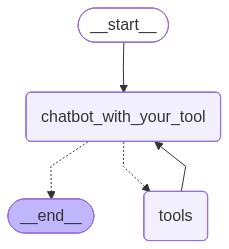

In [14]:

llm_with_your_tool = llm.bind_tools(tools)

def chatbot_with_your_tool(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm_with_your_tool.invoke(state["messages"])]}

workflow = StateGraph(GraphState)

workflow.add_node("chatbot_with_your_tool", chatbot_with_your_tool)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "chatbot_with_your_tool")
workflow.add_edge("tools", "chatbot_with_your_tool")

workflow.add_conditional_edges(
    "chatbot_with_your_tool",
    tools_condition
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
user_input = input("User: ")
for event in graph.stream({"messages": ("user", user_input)}):
    for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: 2.0
Assistant: 10 delt på 5 er 2.0.


### Congratulations🎉 You have now created your first tool.

# Structured output

It's pretty common to want LLMs inside nodes to return structured output when building agents. This is because that structured output can often be used to route to the next step (e.g. choose between two different edges) or update specific keys of the state.

Source: [Langchain AI - Structured output](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#structured-output)

A structured output for weather might look like this:
```json
{
  "temperature": 25,
  "humidity": 0.5,
  "wind_speed": 10,
  "wind_direction": "N"
}


In [17]:
from pydantic import BaseModel, Field
from typing import List


class ResumeSummary(BaseModel):
    name: str = Field(..., title="Name of the applicant")
    experience: List[str] = Field(..., title="List of experiences")
    skills: List[str] = Field(..., title="List of skills")

Using the LangChain `.with_structured_output()` method, we can specify the output format of the tool. This will allow us to generate structured output from the tool.

In [18]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""
    {application}
    """
)
chain = prompt | llm.with_structured_output(ResumeSummary)

Lets load some applications and test the structured output.

In [20]:

applications = []
folder_path = os.path.join("data", "applications")
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            applications.append(file.read())

for application in applications:
    print(application)
    print(chain.invoke(application).model_dump_json(indent=2))
    print("\n")


Hi there, Iâ€™m John Smith, Iâ€™ve been working in data science for about 7 years now. For the last 5 years, I was a senior data scientist at TechCorp. My expertise lies in Python, TensorFlow, and machine learning, and Iâ€™ve done a lot of work with time series forecasting too. I also have a PhD in Computer Science. One of my proudest moments was leading a team to build a recommendation system that boosted product discovery by 15%. Iâ€™m really excited to apply for this position because I want to dive deeper into predictive analytics and deploying models at scale.
{
  "name": "John Smith",
  "experience": [
    "Senior Data Scientist at TechCorp for 5 years",
    "Led a team to build a recommendation system that boosted product discovery by 15%",
    "7 years of experience in data science"
  ],
  "skills": [
    "Python",
    "TensorFlow",
    "Machine Learning",
    "Time Series Forecasting",
    "Predictive Analytics",
    "Model Deployment at Scale"
  ]
}


Hey, Sarah here! Iâ€™ve b

## Task 2: **Create a Structured Output from Unstructured Emails**

You are provided with 5 `.txt` files, each containing an email about an office supply order. The emails may include:

- Product names, quantities
- Delivery dates, addresses
- Customer details (names, contacts)

Your task is to create a structured object that captures the relevant data (e.g., products, quantities, delivery info) while handling potential noise and inconsistencies. The structure should be designed for future analysis and flexibility to deal with incomplete or messy information.

### Example Output:
```json
{
    "customer": {
        "name": "John Doe", 
        "company": "ACME Corp"
    },
    "order_items": [
        {
            "product": "Pens",
            "quantity": 10
        }
    ],
    "delivery": {
        "address": "123 Main St",
        "date": "2023-09-12"
    }
}
```

#### Documentation:

- [Langchain AI - Structured Output](https://python.langchain.com/v0.2/docs/how_to/structured_output/)


In [21]:
orders = []
folder_path = os.path.join("data", "orders")
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            orders.append(file.read())

# See how one of the orders look
print(orders[0])

Hi,

Just need the following items for the office:

- 10x notebooks (any color is fine)
- Oh, and can we get 3 desk chairs?

Deliver ASAP to 234 Office Blvd, Suite 150. 

Thanks!
-Jane



You job now is to create the Pydantic object that will be used to structure the information in the emails.

In [22]:
#-----------TASK 2: Write your pydantic object --------------

class Customer(BaseModel):
    name: str = Field(..., title="Customer name")
    company: str = Field(..., title="Company name") 

class OrderItem(BaseModel): 
    product: str = Field(..., title="Product name")
    quantity: int = Field(..., Field="Product quantity") 

class Delivery(BaseModel): 
    address: str = Field(..., title="Adress name") 
    date: int = Field(..., title="Delivery date") 

class Order(BaseModel):
    customer: Customer 
    order_items: List[OrderItem]
    delivery: Delivery

#------------------------------------------------------------

In [23]:
prompt = PromptTemplate(
    template="""
    {order}
    """
)
chain = prompt | llm.with_structured_output(Order)

In [25]:
orders[0]
print(chain.invoke(orders[0]).model_dump_json(indent=2))

{
  "customer": {
    "name": "Jane",
    "company": "Office"
  },
  "order_items": [
    {
      "product": "Notebooks",
      "quantity": 10
    },
    {
      "product": "Desk Chairs",
      "quantity": 3
    }
  ],
  "delivery": {
    "address": "234 Office Blvd, Suite 150",
    "date": 0
  }
}


# Basic Reflection

<div style="text-align:center">
    <img src="./images/Reflection.png" alt="basic agent reflection" width='50%'>
</div>


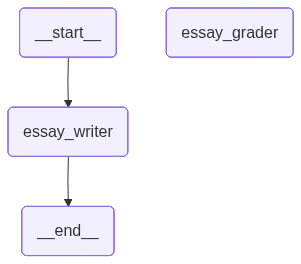

In [31]:
from langchain_core.output_parsers import StrOutputParser

llm_gpt_3_5 = ChatOpenAI(
    model_name="gpt-3.5-turbo",
)

class GraphState(TypedDict):
    essay: str
    feedback: Annotated[list, add_messages]
    iteration: int

def essay_writer(state: GraphState):
    """Node that generate a 3 paragraph essay"""
    print("\n---ESSAY WRITER---")
    iteration = state.get("iteration", 0) + 1
    essay = state["essay"] if "essay" in state else "No essay yet"
    prompt = PromptTemplate(
        template="""
        Write a 3 paragraph essay based on the following feedback:

        Essay: {essay}

        Update the essay based on the feedback:

        Feedback: {feedback}
        """
    )
    generate = prompt | llm_gpt_3_5 | StrOutputParser()
    essay = generate.invoke({"essay": essay, "feedback": state["feedback"]})
    print("\nEssay: ", essay)
    return {"essay": [essay], "iteration": iteration}


def essay_grader(state: GraphState):
    """Node that grades an essay"""
    print("\n---ESSAY GRADER---")
    prompt = PromptTemplate(
        template="""
        You are a teacher grading an essay. Provide clear and consise feedback on how to improve the essay:

        Essay: {essay}
        """
    )
    generate = prompt | llm
    feedback = generate.invoke({"essay": state["essay"] if "essay" in state else "No essay yet"})
    print("\nFeedback: ", feedback)
    return {"feedback": [feedback]}


def should_continue(state: GraphState):
    """Node that checks if the user wants to continue"""
    print("\n---SHOULD CONTINUE---")
    if state.get("iteration", 0) >= 3:
        return "__end__"
    else:
        return "essay_grader"


workflow = StateGraph(GraphState)

workflow.add_node("essay_writer", essay_writer)
workflow.add_node("essay_grader", essay_grader)

workflow.add_edge(START, "essay_writer")
workflow.add_edge("essay_grader", "essay_writer")

workflow.add_conditional_edges(
    "essay_writer",
    should_continue
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
request = "Skriv en saktekst om Norges Teknisk-Naturvitenskapelige Universitet i Trondheim."

essay = graph.invoke({"feedback": [request]})
print("Essay: ", essay["essay"])


---ESSAY WRITER---

Essay:  Norges Teknisk-Naturvitenskapelige Universitet (NTNU) i Trondheim er et ledende universitet innen teknisk og naturvitenskapelig forskning og utdanning i Norge. Universitetet ble grunnlagt i 1910 og har siden den gang vokst til å bli et av landets mest anerkjente læresteder. NTNU tilbyr et bredt spekter av studieprogrammer innen ingeniørfag, naturvitenskap, medisin, samfunnsvitenskap og humaniora, og har et sterkt fokus på å integrere forskning i undervisningen sin.

NTNU er kjent for sitt innovative forskningsmiljø og har et tett samarbeid med både nasjonale og internasjonale aktører innen næringsliv, akademia og offentlig sektor. Universitetet har flere fremragende forskningssentre og laboratorier som er dedikert til å løse samfunnsutfordringer og drive frem banebrytende vitenskapelige oppdagelser. NTNU legger vekt på å bidra til bærekraftig utvikling gjennom sin forskning og utdanning, og er engasjert i å løse globale problemstillinger som klimaendringer,

## Task 3: **Create a code-generating agent with self reflection**

### Motivation
Code generation and analysis are two of most important applications of LLMs, as shown by the ubiquity of products like GitHub co-pilot and popularity of projects like GPT-engineer. The recent AlphaCodium work showed that code generation can be improved by using a flow paradigm rather than a naive prompt:answer paradigm: answers can be iteratively constructed by (1) testing answers and (2) reflecting on the results of these tests in order to improve the solution.

### Task
Create an agent that generates code based on what the user wants. Take a look at this flow diagram:

<div style="text-align:left">
    <img src="./images/Code-Generation.png" alt="basic agent reflection" width='50%'>
</div>

You are free to choose the complexity of the task with these suggestions:
1. Code execution: Create a tool that executes the code generated by the agent.
2. Documentation: Create a tool that retrieves the documentation of a given library.
3. Add support for multiple programming languages.


In [33]:
from pydantic import BaseModel, Field
from typing import TypedDict, Optional


class GeneratedCode(BaseModel):
    preamble: str = Field(..., description="Short description of the code")
    imports: str = Field(..., description="Python import statements")
    code: str = Field(..., description="The actual code implementation")

class GraphState(TypedDict):
    question: str
    generated_code: Optional[GeneratedCode]
    error: Optional[str]
    import_ok: bool
    execution_ok: bool


In [34]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm_structured = llm.with_structured_output(GeneratedCode)

def generation_node(state: GraphState):
    """LLM generates code based on the users question"""
    result = llm_structured.invoke(state["question"])
    return {"generated_code": result, "error": None}

def import_check_node(state: GraphState):
    """Checks if imports work"""
    try:
        exec(state["generated_code"].imports, {})
        return {"import_ok": True, "error": None}
    except Exception as exception:
        return {"import_ok": False, "error": str(exception)}

def execution_check_node(state: GraphState):
    """Tries to execute the code"""
    try:
        exec(state["generated_code"].imports + "\n" + state["generated_code"].code, {})
        return {"execution_ok": True, "error": None}
    except Exception as exception:
        return {"execution_ok": False, "error": str(exception)}


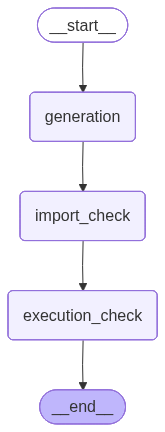

In [35]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

workflow = StateGraph(GraphState)

workflow.add_node("generation", generation_node)
workflow.add_node("import_check", import_check_node)
workflow.add_node("execution_check", execution_check_node)

workflow.add_edge(START, "generation")
workflow.add_edge("generation", "import_check")
workflow.add_edge("import_check", "execution_check")
workflow.add_edge("execution_check", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


#### Now its time to see if the agent will work🤩

In [37]:
request = input("What do you want to generate? ")
generated_code = graph.invoke({"question": request})

print("\nImports:\n", generated_code["generated_code"].imports)
print("\nCode:\n", generated_code["generated_code"].code)
print("\nExecution OK:", generated_code["execution_ok"])
print("Error:", generated_code["error"])


Standard Deviation: 14.142135623730951

Imports:
 import numpy as np

Code:
 # Define a list of numbers
numbers = [10, 20, 30, 40, 50]

# Calculate the standard deviation
std_dev = np.std(numbers)

# Print the result
print(f'Standard Deviation: {std_dev}')

Execution OK: True
Error: None


## This is the end of the workshop. We hope you enjoyed it.🎉